In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "150705",
                             database = "ecommerce")
cur = db.cursor()

# Calculate the moving average of order values for each customer over their order history.


In [67]:
query = """ select customer_id,order_purchase_timestamp, payments,
avg(payments) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from (select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payments
from payments join orders
on payments.order_id = orders.order_id) as a"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [68]:
query = """ select years,months, payments,sum(payments)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments from orders join payments
on orders.order_id = payments.order_id 
group by years,months order by years,months) as a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales

In [69]:
query = """with c as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id 
group by years order by years)

select years,((payment-lag(payment,1) over(order by years))/
lag(payment,1) over(order by years)) * 100 from c"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years","year over year% growth"])
df

,years,year over year% growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [70]:
query = """ with a as (select  customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""
cur.execute(query)

data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

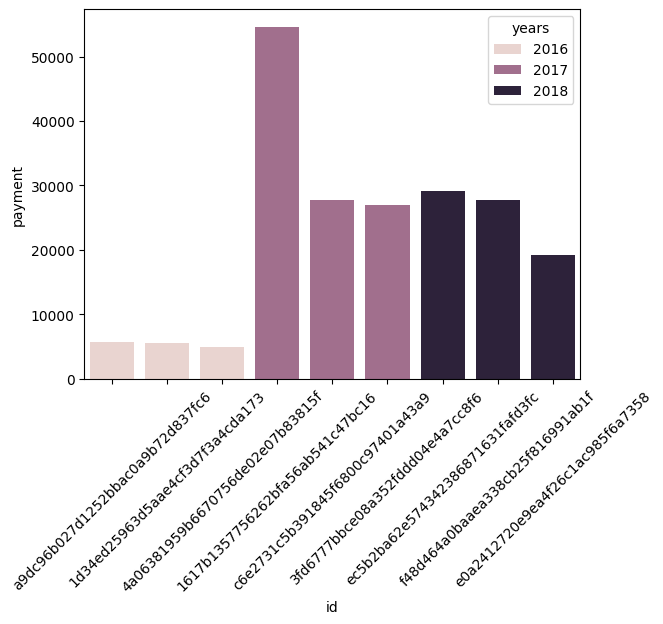

In [71]:
query = """ select years,customer_id,payment,d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id)  as a
where d_rank <= 3 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["years","id","payment","rank"])
sns.barplot(x ="id", y = "payment" ,data = df,hue = "years")
plt.xticks(rotation = 45)
plt.show()